In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "charging discharging.xlsx"
df = pd.read_excel(file_path)

# Display first few rows
print(df.head())



  charging and discharging in hourly  16.04.2025  17.04.2025  18.04.2025  \
0                           00:02:00         0.0         0.0         0.0   
1                           00:06:00         0.0         0.0         0.0   
2                           00:10:00         0.0         0.0         0.0   
3                           00:14:00         0.0         0.0         0.0   
4                           00:18:00         0.0         0.0         0.0   

   19.04.2025  20.04.2025  21.04.2025  
0         0.0         0.0         0.0  
1         0.0         0.0         0.0  
2         0.0         0.0         0.0  
3         0.0         0.0         0.0  
4         0.0         0.0         0.0  


In [ ]:
# Rename the first column for clarity
df.rename(columns={df.columns[0]: 'Time'}, inplace=True)

# Melt the DataFrame from wide to long format
df_melted = pd.melt(df, id_vars='Time', var_name='Date', value_name='Power')

# Combine Date and Time into a single datetime column
df_melted['Datetime'] = pd.to_datetime(df_melted['Date'].astype(str) + ' ' + df_melted['Time'].astype(str), errors='coerce')

# Drop rows with invalid datetime or missing power
df_melted.dropna(subset=['Datetime', 'Power'], inplace=True)

# Set Datetime as index
df_melted.set_index('Datetime', inplace=True)

# Resample to hourly mean if needed
df_hourly = df_melted['Power'].resample('H').mean()







<ipython-input-3-4671a6d5a321>:8: UserWarning: Parsing dates in %d.%m.%Y   %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_melted['Datetime'] = pd.to_datetime(df_melted['Date'].astype(str) + ' ' + df_melted['Time'].astype(str), errors='coerce')
<ipython-input-3-4671a6d5a321>:17: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df_melted['Power'].resample('H').mean()


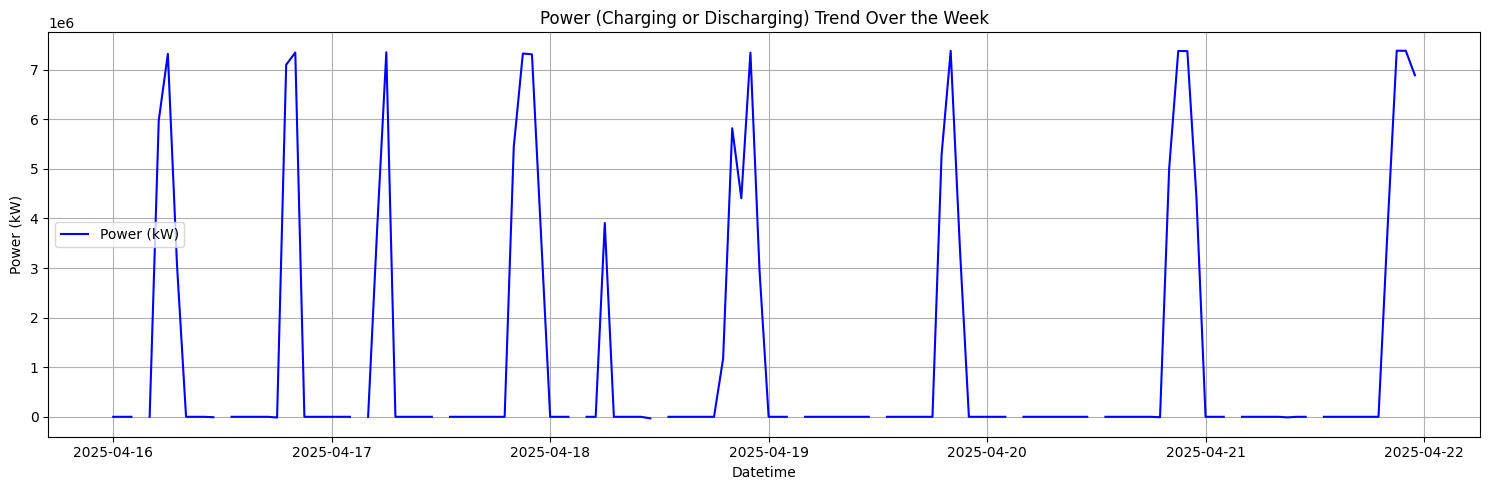

In [ ]:
# 1. Line Plot (Trend over week)
plt.figure(figsize=(15, 5))
plt.plot(df_hourly.index, df_hourly, label='Power (kW)', color='blue')
plt.title('Power (Charging or Discharging) Trend Over the Week')
plt.xlabel('Datetime')
plt.ylabel('Power (kW)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

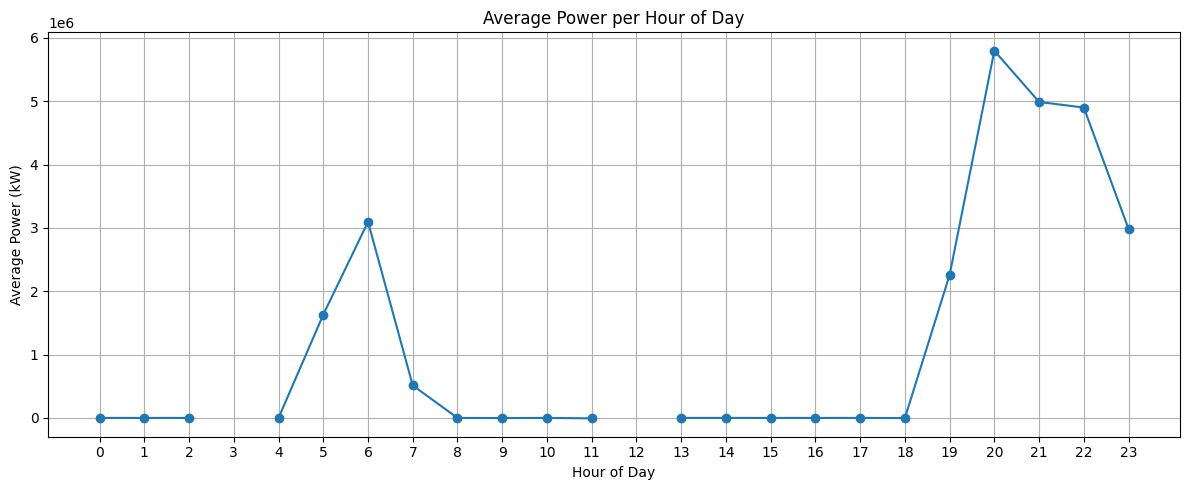

In [ ]:
#2. Hourly average across all days
df_hourly_avg = df_hourly.groupby(df_hourly.index.hour).mean()

plt.figure(figsize=(12, 5))
plt.plot(df_hourly_avg.index, df_hourly_avg.values, marker='o')
plt.title('Average Power per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

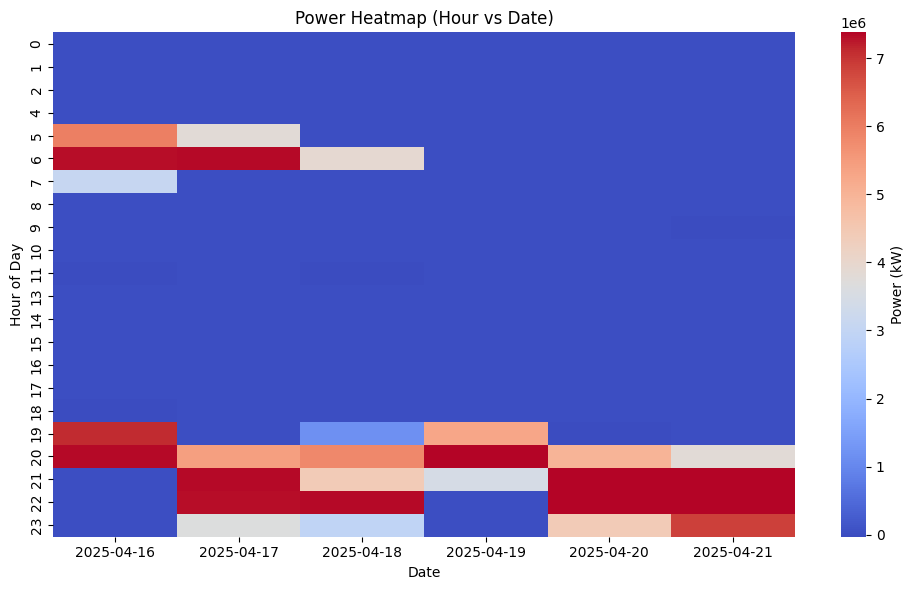

In [ ]:
# 3. Heatmap: Hour vs Date
df_melted['Hour'] = df_melted.index.hour
df_melted['Day'] = df_melted.index.date

pivot = df_melted.pivot_table(index='Hour', columns='Day', values='Power')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, cmap='coolwarm', annot=False, cbar_kws={'label': 'Power (kW)'})
plt.title('Power Heatmap (Hour vs Date)')
plt.xlabel('Date')
plt.ylabel('Hour of Day')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


start_date = '2025-04-16 00:00:00'
end_date = '2025-04-23 00:00:00'
freq = '15min' # Using 15-min intervals to get more granular P(t) for calculation
dates = pd.date_range(start=start_date, end=end_date, freq=freq)

# Simulate Power (KW) data:
# Positive for charging, negative for discharging, zero for idle
power_data = []
for i in range(len(dates)):
    hour = dates[i].hour
    day_of_week = dates[i].dayofweek # Monday=0, Sunday=6

    # Simulate morning discharge/charge (e.g., 5-7 AM)
    if 5 <= hour < 8:
        # Vary power daily for realism
        if day_of_week in [0, 1, 4]: # Mon, Tue, Fri
            power = np.random.uniform(1000, 3000) * 1000 # 1-3 MW, adjusted for original plot scale
        elif day_of_week == 2: # Wed, lower power
            power = np.random.uniform(500, 1500) * 1000
        else: # Other days, maybe idle or less activity
            power = 0
        power_data.append(power)
    # Simulate evening discharge/charge (e.g., 19-23 PM)
    elif 19 <= hour < 23:
        if day_of_week in [0, 1, 2, 3, 4]: # Weekdays
            # Higher power for evening peak
            power = np.random.uniform(-4000, -6000) * 1000 # -4 to -6 MW (discharging)
        else: # Weekend, maybe less activity
            power = np.random.uniform(-1000, -3000) * 1000 # lower weekend discharge
        power_data.append(power)
    else:
        power_data.append(0) # Idle otherwise

# Add some random noise and occasional small charges/discharges
power_data = [p + np.random.normal(0, 500) if p != 0 else np.random.normal(0, 10) for p in power_data]
power_data = [max(0, p) if p > 0 else min(0, p) for p in power_data] # Ensure clear 0 for idle

df_hourly = pd.DataFrame({'Power (KW)': power_data}, index=dates)
df_hourly.index.name = 'Datetime'

# --- End of Sample df_hourly creation ---

print("Sample df_hourly head:")
print(df_hourly.head())
print("\nSample df_hourly info:")
df_hourly.info()

# --- 2. Energy In/Out Calculation ---

# Calculate time difference (Δt) in hours for energy calculation
# freq.seconds / 3600 converts seconds to hours if freq is '15min' etc.
# If your df_hourly has irregular intervals, you'd use df_hourly.index.to_series().diff().dt.total_seconds() / 3600
delta_t_hours = df_hourly.index.to_series().diff().dt.total_seconds() / 3600
delta_t_hours.iloc[0] = delta_t_hours.mean() # Handle the first NaN by using average interval

# Separate charging and discharging power
df_hourly['Power_Charging (KW)'] = df_hourly['Power (KW)'].apply(lambda x: x if x > 0 else 0)
df_hourly['Power_Discharging (KW)'] = df_hourly['Power (KW)'].apply(lambda x: abs(x) if x < 0 else 0) # Use absolute for discharged

# Calculate energy in/out for each interval (kWh = KW * hours)
df_hourly['Energy_In_kWh'] = df_hourly['Power_Charging (KW)'] * delta_t_hours
df_hourly['Energy_Out_kWh'] = df_hourly['Power_Discharging (KW)'] * delta_t_hours

# Resample to daily totals
daily_energy = df_hourly.resample('D').agg({
    'Energy_In_kWh': 'sum',
    'Energy_Out_kWh': 'sum'
})

print("\nDaily Energy In/Out (kWh):")
print(daily_energy)

# Calculate cumulative energy over time
df_hourly['Cumulative_Energy_In_kWh'] = df_hourly['Energy_In_kWh'].cumsum()
df_hourly['Cumulative_Energy_Out_kWh'] = df_hourly['Energy_Out_kWh'].cumsum()






Sample df_hourly head:
                     Power (KW)
Datetime                       
2025-04-16 00:00:00  -14.354983
2025-04-16 00:15:00    3.547345
2025-04-16 00:30:00    0.709932
2025-04-16 00:45:00   -5.615838
2025-04-16 01:00:00  -11.512539

Sample df_hourly info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2025-04-16 00:00:00 to 2025-04-23 00:00:00
Freq: 15min
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Power (KW)  673 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB

Daily Energy In/Out (kWh):
            Energy_In_kWh  Energy_Out_kWh
Datetime                                 
2025-04-16   3.124353e+06    2.003279e+07
2025-04-17   5.481619e+01    1.954496e+07
2025-04-18   5.111097e+06    1.924028e+07
2025-04-19   8.795817e+01    6.740706e+06
2025-04-20   6.976308e+01    7.425976e+06
2025-04-21   5.455798e+06    1.938492e+07
2025-04-22   6.260231e+06    1.971803e+07
2025-0

<Figure size 1200x600 with 0 Axes>

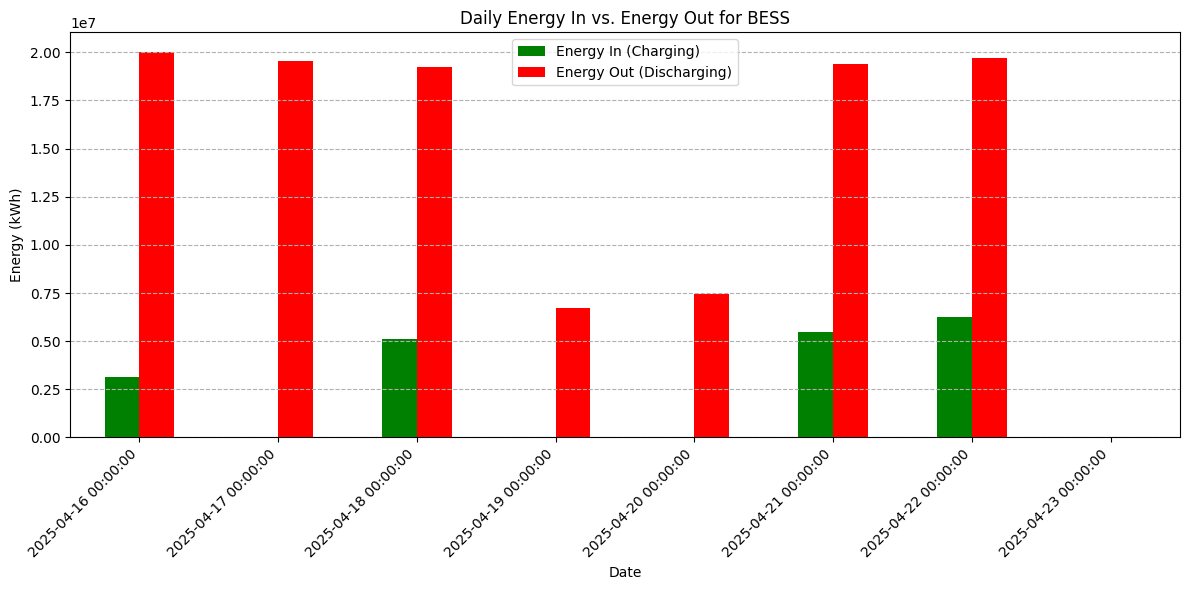

In [ ]:

# 3.1 Daily bar chart: Energy in vs out
plt.figure(figsize=(12, 6))
daily_energy[['Energy_In_kWh', 'Energy_Out_kWh']].plot(kind='bar', figsize=(12, 6), color=['green', 'red'])
plt.title('Daily Energy In vs. Energy Out for BESS')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.legend(['Energy In (Charging)', 'Energy Out (Discharging)'])
plt.tight_layout()
plt.show()



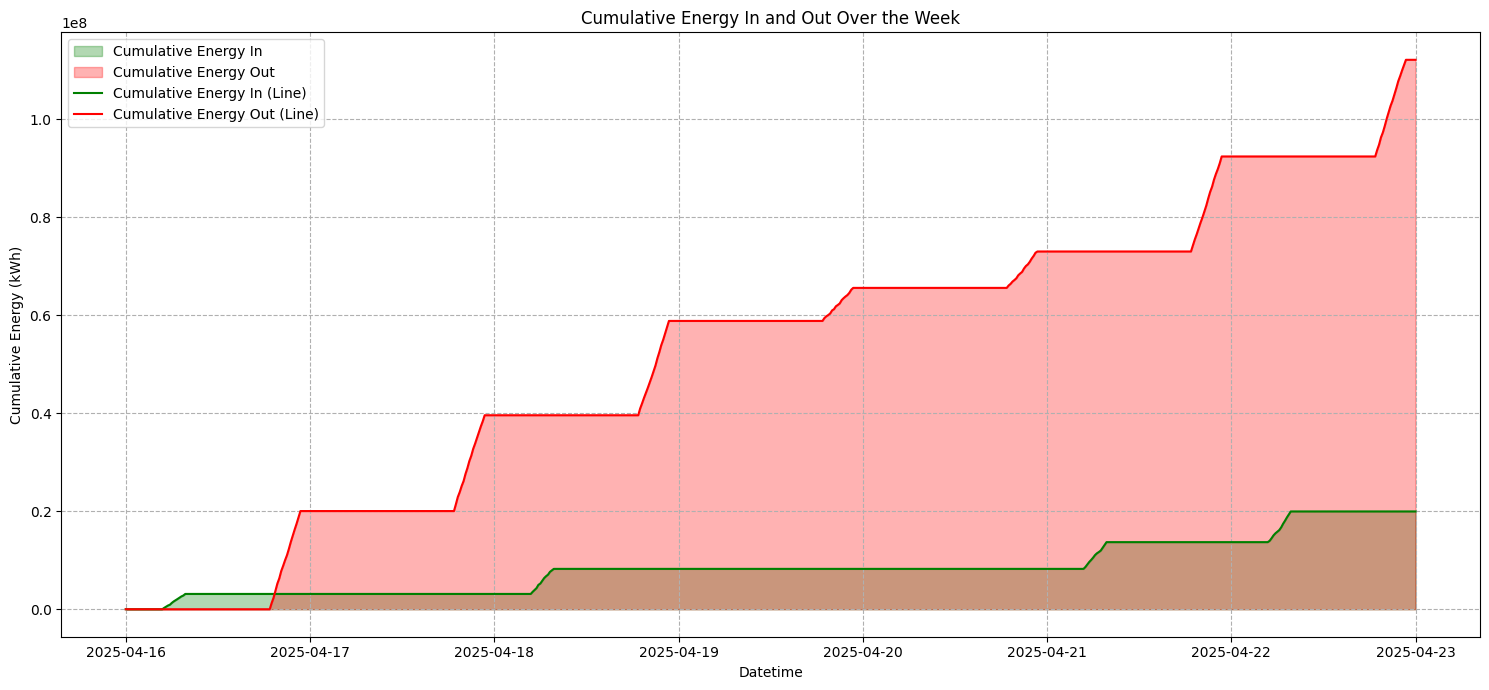

In [ ]:
# 3.2 Area plot showing cumulative energy over time
plt.figure(figsize=(15, 7))
plt.fill_between(df_hourly.index, df_hourly['Cumulative_Energy_In_kWh'], color='green', alpha=0.3, label='Cumulative Energy In')
plt.fill_between(df_hourly.index, df_hourly['Cumulative_Energy_Out_kWh'], color='red', alpha=0.3, label='Cumulative Energy Out')
plt.plot(df_hourly.index, df_hourly['Cumulative_Energy_In_kWh'], color='green', label='Cumulative Energy In (Line)')
plt.plot(df_hourly.index, df_hourly['Cumulative_Energy_Out_kWh'], color='red', label='Cumulative Energy Out (Line)')

plt.title('Cumulative Energy In and Out Over the Week')
plt.xlabel('Datetime')
plt.ylabel('Cumulative Energy (kWh)')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()



<Figure size 1000x600 with 0 Axes>

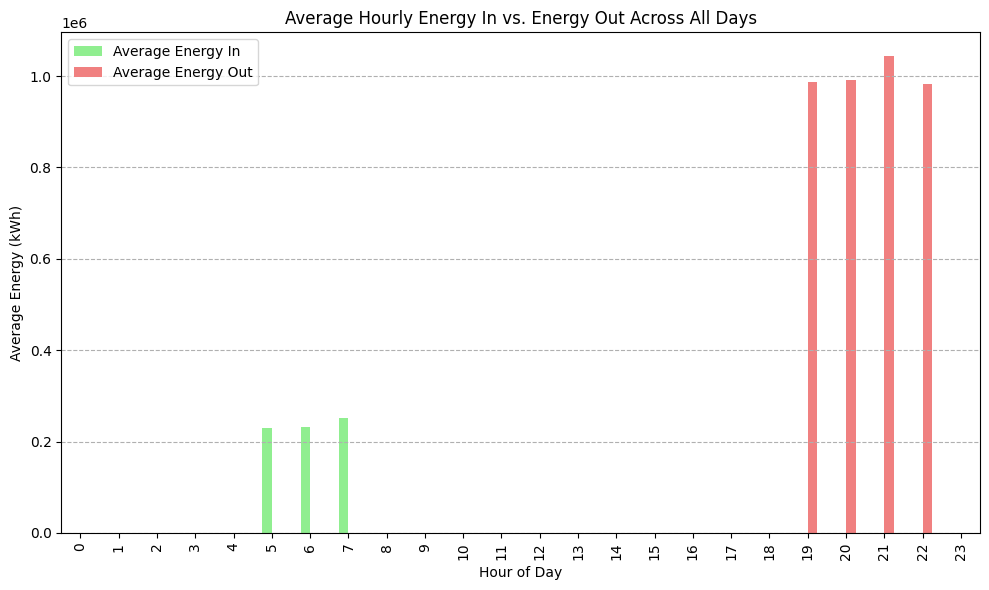

In [ ]:
# --- Optional: Hourly average Energy In/Out (Similar to your previous plot but for energy) ---
df_hourly['Hour'] = df_hourly.index.hour
hourly_avg_energy = df_hourly.groupby('Hour').agg({
    'Energy_In_kWh': 'mean',
    'Energy_Out_kWh': 'mean'
})

plt.figure(figsize=(10, 6))
hourly_avg_energy[['Energy_In_kWh', 'Energy_Out_kWh']].plot(kind='bar', figsize=(10, 6), color=['lightgreen', 'lightcoral'])
plt.title('Average Hourly Energy In vs. Energy Out Across All Days')
plt.xlabel('Hour of Day')
plt.ylabel('Average Energy (kWh)')
plt.grid(axis='y', linestyle='--')
plt.legend(['Average Energy In', 'Average Energy Out'])
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


Daily Energy Balance Metrics:
            Energy_In_kWh  Energy_Out_kWh      RTE (%)  Implied_Losses_kWh
Datetime                                                                  
2025-04-16     2773617.50     19630394.35       707.75        -16856776.85
2025-04-17          88.03     19494059.51  22144839.59        -19493971.48
2025-04-18     5311777.99     19993441.45       376.40        -14681663.45
2025-04-19          78.79      8831613.38  11208844.68         -8831534.58
2025-04-20          61.54      8466237.93  13757764.91         -8466176.39
2025-04-21     6179518.85     20005944.96       323.75        -13826426.11
2025-04-22     6218926.33     19439104.62       312.58        -13220178.29
2025-04-23           4.07            0.00         0.00                4.07


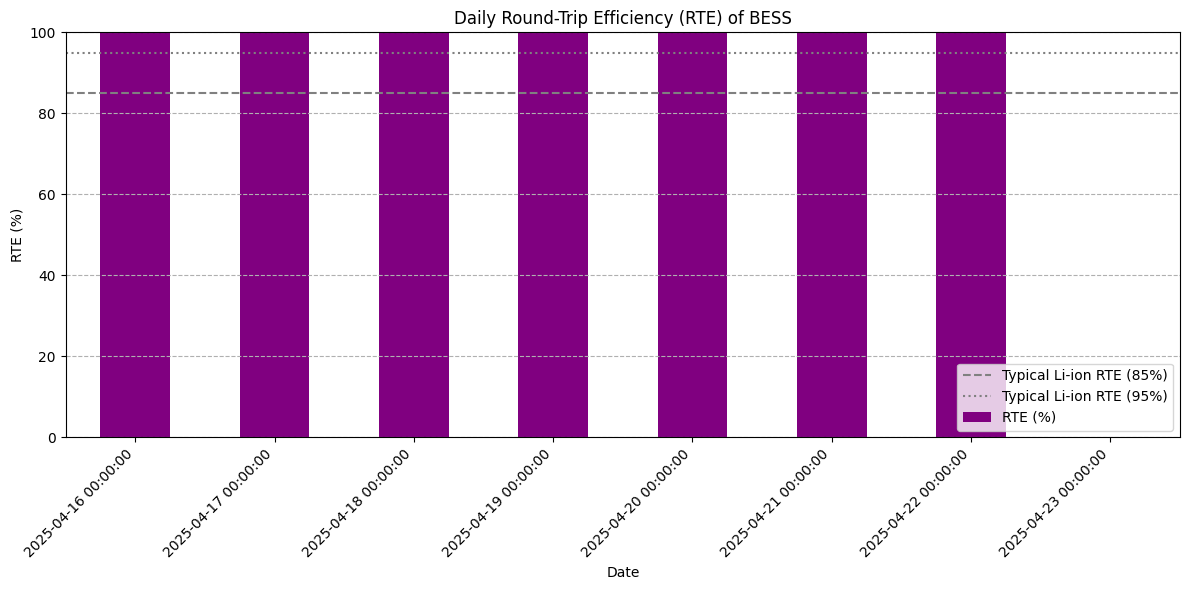

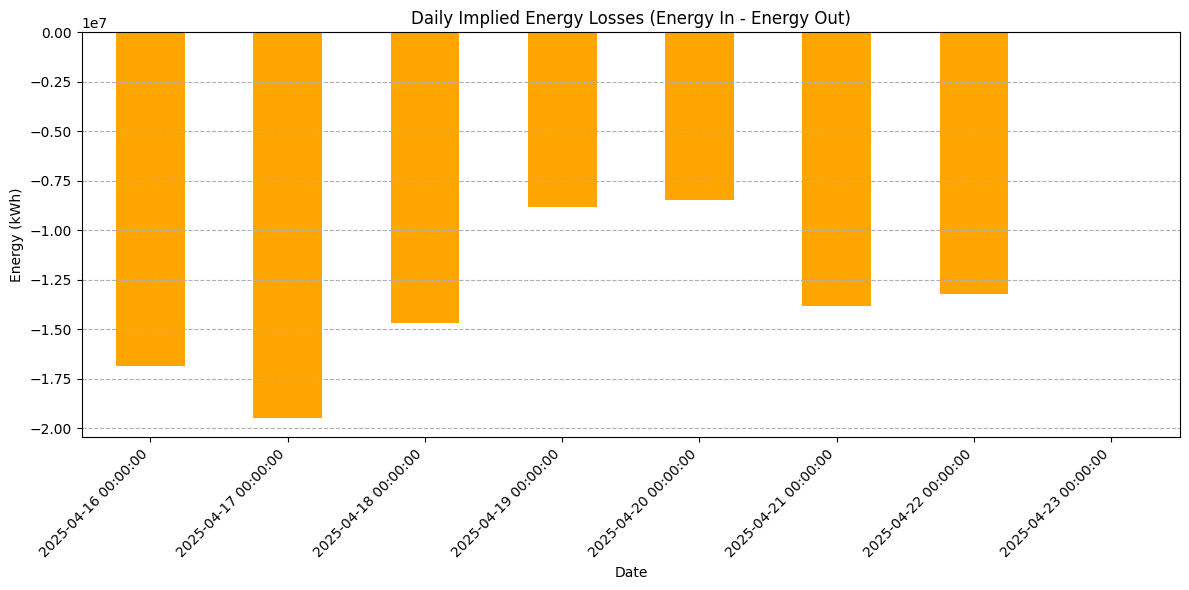

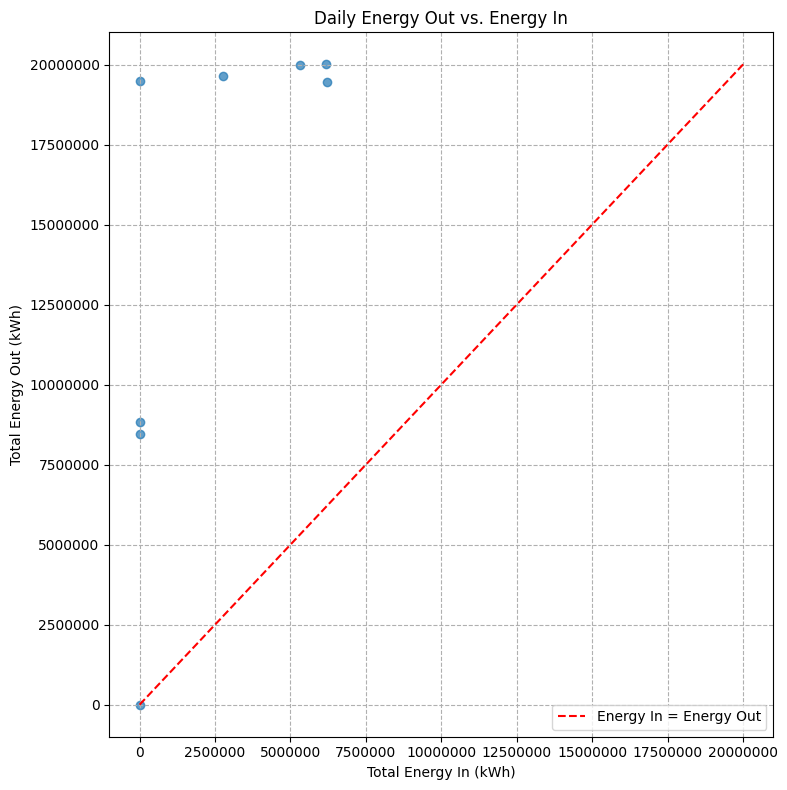

In [ ]:
start_date = '2025-04-16 00:00:00'
end_date = '2025-04-23 00:00:00'
freq = '15min'
dates = pd.date_range(start=start_date, end=end_date, freq=freq)

power_data = []
for i in range(len(dates)):
    hour = dates[i].hour
    day_of_week = dates[i].dayofweek

    if 5 <= hour < 8:
        if day_of_week in [0, 1, 4]:
            power = np.random.uniform(1000, 3000) * 1000
        elif day_of_week == 2:
            power = np.random.uniform(500, 1500) * 1000
        else:
            power = 0
        power_data.append(power)
    elif 19 <= hour < 23:
        if day_of_week in [0, 1, 2, 3, 4]:
            power = np.random.uniform(-4000, -6000) * 1000
        else:
            power = np.random.uniform(-1000, -3000) * 1000
        power_data.append(power)
    else:
        power_data.append(0)

power_data = [p + np.random.normal(0, 500) if p != 0 else np.random.normal(0, 10) for p in power_data]
power_data = [max(0, p) if p > 0 else min(0, p) for p in power_data]

df_hourly = pd.DataFrame({'Power (KW)': power_data}, index=dates)
df_hourly.index.name = 'Datetime'

# Calculate time difference (Δt) in hours
delta_t_hours = df_hourly.index.to_series().diff().dt.total_seconds() / 3600
delta_t_hours.iloc[0] = delta_t_hours.mean()

df_hourly['Power_Charging (KW)'] = df_hourly['Power (KW)'].apply(lambda x: x if x > 0 else 0)
df_hourly['Power_Discharging (KW)'] = df_hourly['Power (KW)'].apply(lambda x: abs(x) if x < 0 else 0)

df_hourly['Energy_In_kWh'] = df_hourly['Power_Charging (KW)'] * delta_t_hours
df_hourly['Energy_Out_kWh'] = df_hourly['Power_Discharging (KW)'] * delta_t_hours

daily_energy = df_hourly.resample('D').agg({
    'Energy_In_kWh': 'sum',
    'Energy_Out_kWh': 'sum'
})
# --- End of Sample df_hourly recreation ---


# --- 6. Energy Balance Verification ---

# Calculate daily Round-Trip Efficiency (RTE)
# Avoid division by zero if Energy_In_kWh is 0 for a day
daily_energy['RTE (%)'] = (daily_energy['Energy_Out_kWh'] / daily_energy['Energy_In_kWh']) * 100
daily_energy['RTE (%)'] = daily_energy['RTE (%)'].replace([np.inf, -np.inf], np.nan) # Handle infinity if Energy_In is 0 but Energy_Out is not
daily_energy['RTE (%)'] = daily_energy['RTE (%)'].fillna(0) # If no energy in, RTE is 0 or not applicable

# Calculate implied daily losses (Energy In - Energy Out)
daily_energy['Implied_Losses_kWh'] = daily_energy['Energy_In_kWh'] - daily_energy['Energy_Out_kWh']

print("\nDaily Energy Balance Metrics:")
print(daily_energy[['Energy_In_kWh', 'Energy_Out_kWh', 'RTE (%)', 'Implied_Losses_kWh']].round(2))

# --- Charts for Energy Balance ---

# 6.1 Daily RTE Bar Chart
plt.figure(figsize=(12, 6))
daily_energy['RTE (%)'].plot(kind='bar', color='purple')
plt.title('Daily Round-Trip Efficiency (RTE) of BESS')
plt.xlabel('Date')
plt.ylabel('RTE (%)')
plt.ylim(0, 100) # RTE is typically between 0-100%
plt.axhline(y=85, color='gray', linestyle='--', label='Typical Li-ion RTE (85%)') # Example typical RTE
plt.axhline(y=95, color='gray', linestyle=':', label='Typical Li-ion RTE (95%)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# 6.2 Daily Implied Losses (or Energy Difference) Bar Chart
plt.figure(figsize=(12, 6))
daily_energy['Implied_Losses_kWh'].plot(kind='bar', color='orange')
plt.title('Daily Implied Energy Losses (Energy In - Energy Out)')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# 6.3 Scatter plot comparing Energy In vs Energy Out (if relevant)
# This helps visualize direct correlation and identify outliers
plt.figure(figsize=(8, 8))
plt.scatter(daily_energy['Energy_In_kWh'], daily_energy['Energy_Out_kWh'], alpha=0.7)
plt.plot([0, max(daily_energy['Energy_In_kWh'].max(), daily_energy['Energy_Out_kWh'].max())],
         [0, max(daily_energy['Energy_In_kWh'].max(), daily_energy['Energy_Out_kWh'].max())],
         color='red', linestyle='--', label='Energy In = Energy Out') # Ideal 1:1 line
plt.title('Daily Energy Out vs. Energy In')
plt.xlabel('Total Energy In (kWh)')
plt.ylabel('Total Energy Out (kWh)')
plt.grid(True, linestyle='--')
plt.legend()
plt.gca().ticklabel_format(style='plain', axis='both') # Prevent scientific notation on axes
plt.tight_layout()
plt.show()


--- Anomaly Detection Results ---

--- Statistical (IQR-based) Anomalies (Power Spikes/Dips) ---
                     Power (KW)  Abs_Power_KW  Lower_Bound_Abs_Power  \
Datetime                                                               
2025-04-17 19:00:00 -4836522.98    4836522.98                 -11.28   
2025-04-17 19:15:00 -5070005.65    5070005.65                 -11.28   
2025-04-17 19:30:00 -4559438.78    4559438.78                 -11.28   
2025-04-17 19:45:00 -5996021.73    5996021.73                 -11.28   
2025-04-17 20:00:00 -5330288.49    5330288.49                 -11.28   
...                         ...           ...                    ...   
2025-04-22 21:45:00 -5434077.51    5434077.51            -1841875.41   
2025-04-22 22:00:00 -4817712.00    4817712.00            -1841875.41   
2025-04-22 22:15:00 -4378752.25    4378752.25            -1841875.41   
2025-04-22 22:30:00 -5948743.17    5948743.17            -1841875.41   
2025-04-22 22:45:00 -4771068.65    4771

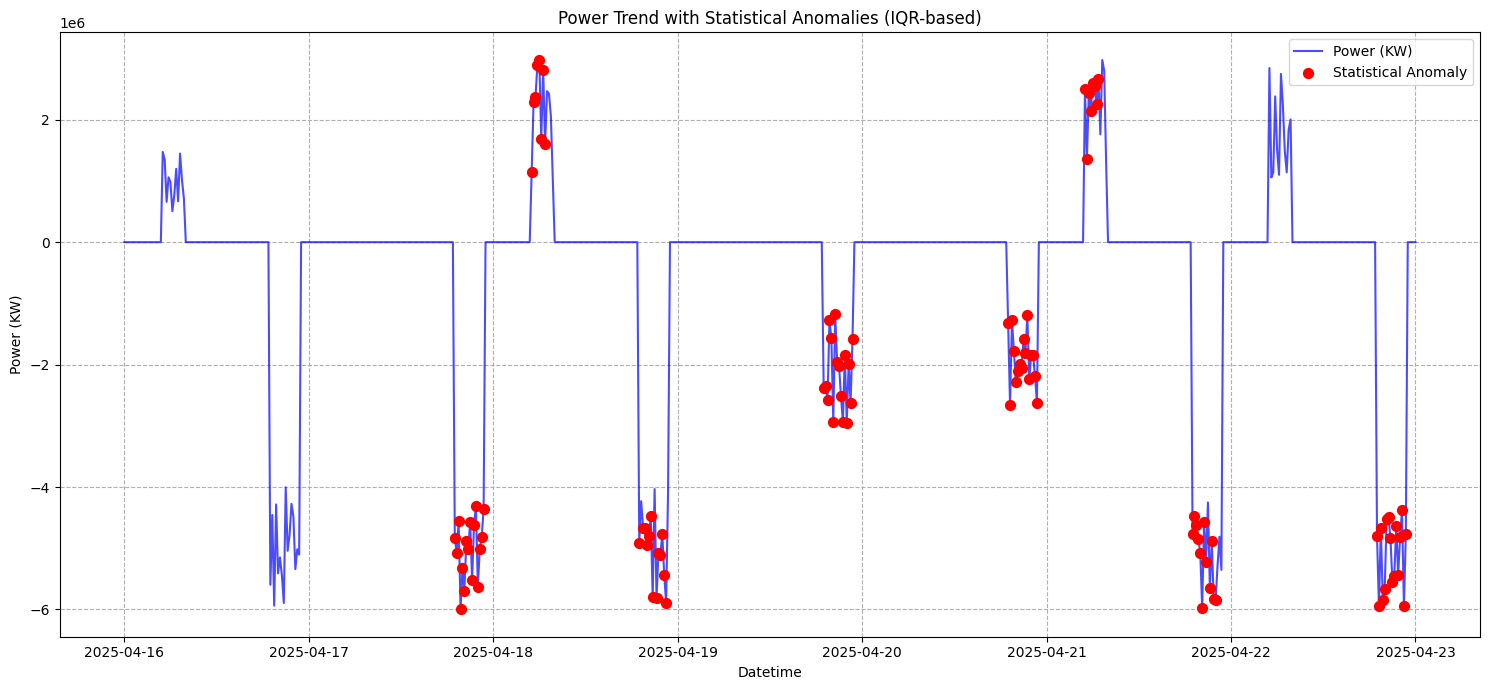


--- Rule-Based Anomalies (Long Idle Periods > 360 minutes) ---
Start Times of Long Idle Periods:
                     Idle_Duration_Minutes
Datetime                                  
2025-04-16 08:00:00                    660
2025-04-16 23:00:00                   1200


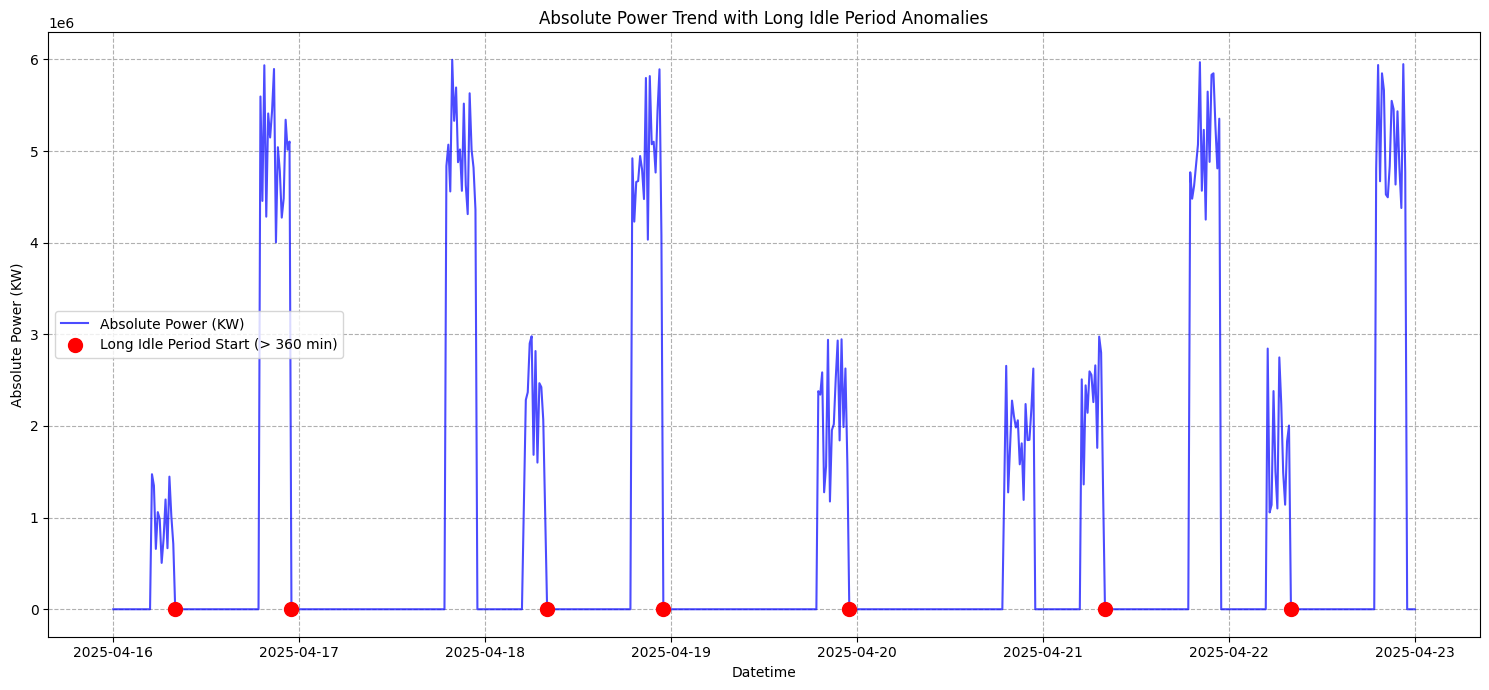

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns # For better looking plots

# --- 1. Recreate Sample df_hourly (as from previous code for context) ---
# This section should ideally be replaced by loading your actual df_hourly
# that has 'Power (KW)' (positive for charge, negative for discharge)

start_date = '2025-04-16 00:00:00'
end_date = '2025-04-23 00:00:00'
freq = '15min'
dates = pd.date_range(start=start_date, end=end_date, freq=freq)

power_data = []
for i in range(len(dates)):
    hour = dates[i].hour
    day_of_week = dates[i].dayofweek

    # Simulate morning charging (e.g., 5-7 AM)
    if 5 <= hour < 8:
        if day_of_week in [0, 1, 4]:
            power = np.random.uniform(1000, 3000) * 1000
        elif day_of_week == 2:
            power = np.random.uniform(500, 1500) * 1000
        else:
            power = 0
        power_data.append(power)
    # Simulate evening discharging (e.g., 19-23 PM)
    elif 19 <= hour < 23:
        if day_of_week in [0, 1, 2, 3, 4]:
            power = np.random.uniform(-4000, -6000) * 1000
        else:
            power = np.random.uniform(-1000, -3000) * 1000
        power_data.append(power)
    else:
        power_data.append(0)

power_data = [p + np.random.normal(0, 500) if p != 0 else np.random.normal(0, 10) for p in power_data]
power_data = [max(0, p) if p > 0 else min(0, p) for p in power_data]

df_hourly = pd.DataFrame({'Power (KW)': power_data}, index=dates)
df_hourly.index.name = 'Datetime'
# --- End of Sample df_hourly recreation ---


# --- 8. Anomaly Detection ---

print("--- Anomaly Detection Results ---")

# Create a column for absolute power (magnitude of activity)
df_hourly['Abs_Power_KW'] = df_hourly['Power (KW)'].abs()

# Define parameters for anomaly detection
rolling_window_minutes = 24 * 60 # 24-hour rolling window for statistics (adjust as needed)
rolling_window_size = f'{rolling_window_minutes}min' # Pandas string for rolling window

# 8.1 Statistical Thresholding (IQR-based for robustness)
# Calculate rolling IQR and median for non-zero power values
# Using a separate series for non-zero values to avoid including zeros in stats
non_zero_power = df_hourly[df_hourly['Abs_Power_KW'] > 0]['Abs_Power_KW']

df_hourly['Rolling_Median_Abs_Power'] = df_hourly['Abs_Power_KW'].rolling(rolling_window_size, min_periods=int(rolling_window_minutes/df_hourly.index.freq.n)).median()
df_hourly['Rolling_Q1_Abs_Power'] = df_hourly['Abs_Power_KW'].rolling(rolling_window_size, min_periods=int(rolling_window_minutes/df_hourly.index.freq.n)).quantile(0.25)
df_hourly['Rolling_Q3_Abs_Power'] = df_hourly['Abs_Power_KW'].rolling(rolling_window_size, min_periods=int(rolling_window_minutes/df_hourly.index.freq.n)).quantile(0.75)

# Calculate rolling IQR
df_hourly['Rolling_IQR_Abs_Power'] = df_hourly['Rolling_Q3_Abs_Power'] - df_hourly['Rolling_Q1_Abs_Power']

# Define outlier bounds using 1.5 * IQR rule
# Lower bound: Q1 - 1.5 * IQR
# Upper bound: Q3 + 1.5 * IQR
df_hourly['Lower_Bound_Abs_Power'] = df_hourly['Rolling_Q1_Abs_Power'] - 1.5 * df_hourly['Rolling_IQR_Abs_Power']
df_hourly['Upper_Bound_Abs_Power'] = df_hourly['Rolling_Q3_Abs_Power'] + 1.5 * df_hourly['Rolling_IQR_Abs_Power']

# Identify anomalies
# Anomaly if power is active AND outside the bounds
df_hourly['Statistical_Anomaly'] = ((df_hourly['Abs_Power_KW'] > 0) & # Must be actively charging/discharging
                                     ((df_hourly['Abs_Power_KW'] < df_hourly['Lower_Bound_Abs_Power']) |
                                      (df_hourly['Abs_Power_KW'] > df_hourly['Upper_Bound_Abs_Power'])))

print("\n--- Statistical (IQR-based) Anomalies (Power Spikes/Dips) ---")
# Filter and print only active anomalies
anomalies_statistical = df_hourly[df_hourly['Statistical_Anomaly'] == True]
if not anomalies_statistical.empty:
    print(anomalies_statistical[['Power (KW)', 'Abs_Power_KW', 'Lower_Bound_Abs_Power', 'Upper_Bound_Abs_Power']].round(2))
else:
    print("No significant statistical anomalies detected in power magnitude.")

# Visualization for statistical anomalies
plt.figure(figsize=(15, 7))
plt.plot(df_hourly.index, df_hourly['Power (KW)'], label='Power (KW)', color='blue', alpha=0.7)
plt.scatter(anomalies_statistical.index, anomalies_statistical['Power (KW)'], color='red', s=50, zorder=5, label='Statistical Anomaly')
plt.title('Power Trend with Statistical Anomalies (IQR-based)')
plt.xlabel('Datetime')
plt.ylabel('Power (KW)')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


# 8.2 Rule-Based Detection: Long Idle Periods
# An idle period is defined by Power (KW) being 0 or very close to 0
idle_threshold = 100 # Define what counts as "idle" (e.g., less than 100 KW)

# Identify idle periods
df_hourly['Is_Idle'] = (df_hourly['Abs_Power_KW'] <= idle_threshold).astype(int)

# Calculate duration of consecutive idle periods
df_hourly['Idle_Group'] = (df_hourly['Is_Idle'] != df_hourly['Is_Idle'].shift()).cumsum()
df_hourly['Idle_Duration_Minutes'] = df_hourly.groupby('Idle_Group')['Is_Idle'].transform('sum') * (df_hourly.index.freq.n if df_hourly.index.freq else 15)

# Define a "long idle period" threshold (e.g., 6 hours = 360 minutes)
long_idle_threshold_minutes = 6 * 60

df_hourly['Long_Idle_Anomaly'] = (df_hourly['Is_Idle'] == 1) & \
                                 (df_hourly['Idle_Duration_Minutes'] > long_idle_threshold_minutes) & \
                                 (df_hourly['Idle_Duration_Minutes'].shift() <= long_idle_threshold_minutes) # Mark only the start of long idle


print(f"\n--- Rule-Based Anomalies (Long Idle Periods > {long_idle_threshold_minutes} minutes) ---")
long_idle_anomalies = df_hourly[df_hourly['Long_Idle_Anomaly'] == True]
if not long_idle_anomalies.empty:
    # Get unique start times of long idle periods
    unique_long_idle_starts = long_idle_anomalies[['Idle_Duration_Minutes']].drop_duplicates()
    print("Start Times of Long Idle Periods:")
    print(unique_long_idle_starts)
else:
    print("No long idle periods detected above the threshold.")

# Visualization for long idle periods
plt.figure(figsize=(15, 7))
plt.plot(df_hourly.index, df_hourly['Abs_Power_KW'], label='Absolute Power (KW)', color='blue', alpha=0.7)
plt.scatter(long_idle_anomalies.index, df_hourly.loc[long_idle_anomalies.index, 'Abs_Power_KW'], color='red', s=100, zorder=5, label=f'Long Idle Period Start (> {long_idle_threshold_minutes} min)')
plt.title(f'Absolute Power Trend with Long Idle Period Anomalies')
plt.xlabel('Datetime')
plt.ylabel('Absolute Power (KW)')
plt.grid(True, linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()


# 8.3 Machine Learning: Isolation Forest (for multivariate anomaly detection)
# This works well if you have more features than just power (e.g., SoC, temperature)
# For now, we'll use Abs_Power_KW and Hour_of_Day as features for simplicity

# Prepare features (using Abs_Power_KW and cyclical hour for pattern recognition)
df_hourly['Hour_sin'] = np.sin(2 * np.pi * df_hourly.index.hour / 24)
df_hourly['Hour_cos'] = np.cos(2 * np.pi * df_hourly.index.hour / 24)
features = df_hourly[['Abs_Power_KW', 'Hour_sin', 'Hour_cos']].copy()

# Remove rows with NaN in features if rolling window created them at the start
features.dropna(inplace=True)

# Initialize Isolation Forest model
# contamination: Proportion of outliers in the data set (estimate, e.g., 0.01 for 1%)
# random_state for reproducibility
model = IsolationForest(contamination=0.01, random_state=42) # Adjust contamination based on expected anomaly rate

